In [197]:
import tensorflow as tf
import json
from dnn import pipeline
import matplotlib.pyplot as plt
import numpy as np

In [163]:
with open("ex.json","r") as f:
    fields = json.load(f)

In [164]:
# Types of the various fields
{ fields[f][-1] for f in fields }

{'float32', 'float64', 'int16', 'int8'}

In [165]:
features = {}
for f in fields:
    features[f] = tf.FixedLenFeature([], tf.string)
    features[f + "/shape"] = tf.FixedLenFeature([3], tf.int64)

In [166]:
def parser_fn(chosen_fields, metadata):
    features = {}
    for f in chosen_fields:
        features[f] = tf.FixedLenFeature([], tf.string)
        features[f + "/shape"] = tf.FixedLenFeature([3], tf.int64)
        
    type_map = {
        "float32": tf.float32,
        "float64": tf.float64,
        "int8": tf.int8,
        "int16": tf.int16,
    }
    
    def fn(binary):
        record = tf.parse_single_example(binary, features)
        res = []
        for f in chosen_fields:
            sh = record[f + "/shape"]
            ty = type_map[metadata[f][-1]]
            decoded = tf.decode_raw(record[f], ty )
            res.append(tf.reshape(decoded, sh))
        return res
    return fn
            
    

In [167]:
def stacker_fn(chosen_fields):
    def fn(x):
        return tf.concat([x[f] for f in chosen_fields], axis=2)
    return fn

In [168]:
chosen_fields = ["Cloud_Optical_Thickness", "Cloud_Effective_Radius", "Cloud_Water_Path"]

In [227]:
d = (tf.data
    .TFRecordDataset(["ex.tfrecord"])
    .map(parser_fn(chosen_fields, fields))
    .map(stacker_fn(chosen_fields))
    .flat_map(pipeline.patchify_fn(64, 64, len(chosen_fields)))
    .filter(lambda x: tf.reduce_any(tf.not_equal(x, tf.gather_nd(x,[0,0,0]))))
)
y = d.make_one_shot_iterator().get_next()

In [228]:
with tf.Session() as sess:
    x = sess.run(y)

In [213]:
x = x.astype(np.float32)

In [214]:
x[x == -9999] = np.nan

In [216]:
x = x - np.nanmean(x, axis=(0,1)) / np.nanstd(x, axis=(0,1))

In [177]:
x = x - x.mean() / x.std()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


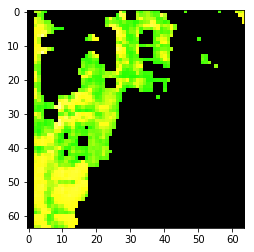

In [234]:
plt.imshow(x)

<TFRecordDataset shapes: (), types: tf.string>

In [309]:
with open("ex.json","r") as f:
    fields = json.load(f)
#     print(fields)

features = {}

for field, (h, w, c, ty) in fields.items():
    size = h * w * c * sizeof[ty]
    features[field] = tf.FixedLenFeature((h, w, c), tf.float32)
#     features[field] = tf.FixedLenFeature(size, tf.string)
    
features.pop("Solar_Azimuth")
features.pop("Cloud_Top_Height_Nadir_Night")
features.pop("Sensor_Azimuth_Night")
features.pop("Latitude")
    
# print(features)
d = tf.data.TFRecordDataset(["ex.tfrecord"])
d = d.map(lambda ser: tf.parse_single_example(ser, features))
    
with tf.Session() as sess:
    x = sess.run(d.make_one_shot_iterator().get_next())

In [312]:
"Longitude" in x.keys()

True

In [298]:
ff = [f for f,m in fields.items() if m[0] == 2030]

In [303]:
for g in ff:
    print(g,"\t\t\t", fields[g])

Cloud_Phase_Infrared_1km 			 [2030, 1354, 1, 'int8']
IRP_CTH_Consistency_Flag_1km 			 [2030, 1354, 1, 'int8']
os_top_flag_1km 			 [2030, 1354, 1, 'int8']
cloud_top_pressure_1km 			 [2030, 1354, 1, 'int16']
cloud_top_height_1km 			 [2030, 1354, 1, 'int16']
cloud_top_temperature_1km 			 [2030, 1354, 1, 'int16']
cloud_emissivity_1km 			 [2030, 1354, 1, 'int8']
cloud_top_method_1km 			 [2030, 1354, 1, 'int8']
surface_temperature_1km 			 [2030, 1354, 1, 'int16']
cloud_emiss11_1km 			 [2030, 1354, 1, 'int16']
cloud_emiss12_1km 			 [2030, 1354, 1, 'int16']
cloud_emiss13_1km 			 [2030, 1354, 1, 'int16']
cloud_emiss85_1km 			 [2030, 1354, 1, 'int16']
Cloud_Effective_Radius 			 [2030, 1354, 1, 'int16']
Cloud_Effective_Radius_PCL 			 [2030, 1354, 1, 'int16']
Cloud_Effective_Radius_16 			 [2030, 1354, 1, 'int16']
Cloud_Effective_Radius_16_PCL 			 [2030, 1354, 1, 'int16']
Cloud_Effective_Radius_37 			 [2030, 1354, 1, 'int16']
Cloud_Effective_Radius_37_PCL 			 [2030, 1354, 1, 'int16']
Cloud_Optical_

# Pipeline for ingesting hdf
1. Select fields from cmdline in train2, flag for fields, flag for hdf
2. filter images that are null -- all Cloud_Water_Path values are the same
3. Patchify and batchify

In [293]:
x

{'Above_Cloud_Water_Vapor_094': array([[[-9999.],
         [-9999.],
         [-9999.],
         ...,
         [-9999.],
         [-9999.],
         [-9999.]],
 
        [[-9999.],
         [-9999.],
         [-9999.],
         ...,
         [-9999.],
         [-9999.],
         [-9999.]],
 
        [[-9999.],
         [-9999.],
         [-9999.],
         ...,
         [-9999.],
         [-9999.],
         [-9999.]],
 
        ...,
 
        [[-9999.],
         [-9999.],
         [  189.],
         ...,
         [-9999.],
         [-9999.],
         [-9999.]],
 
        [[-9999.],
         [-9999.],
         [  157.],
         ...,
         [-9999.],
         [-9999.],
         [-9999.]],
 
        [[-9999.],
         [-9999.],
         [  160.],
         ...,
         [-9999.],
         [-9999.],
         [-9999.]]], dtype=float32),
 'Asymmetry_Parameter_Ice': array([[[0.748],
         [0.749],
         [0.752],
         [0.769],
         [0.802],
         [0.787],
         [0.873]],

In [284]:
for k in x:
    print(k, x[k].shape)

Cirrus_Reflectance (2030, 1354, 1)
Cloud_Optical_Thickness (2030, 1354, 1)
Cloud_Water_Path (2030, 1354, 1)


In [285]:
import matplotlib.pyplot as plt

In [ ]:
a.set_ti

In [288]:
a = ax[i]

### Notes
* PCA -- R^2 of channels
* VAE 2d generated projection
* MSE vs visual quality

### Hyper Parameter search
* Learn rate
* optimizer
* bottleneck width
* kerneal size
* network height
* loss functions
only compare RMSE at the end, homogenous sampling ~ 50k or so images


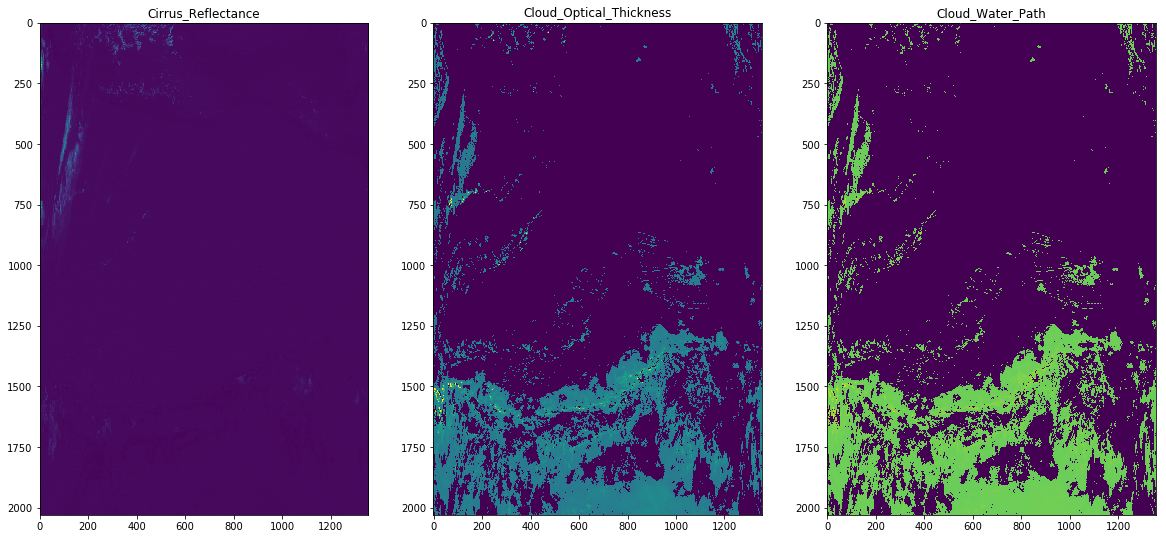

In [291]:
fig, ax = plt.subplots(ncols=len(x), figsize=(20, 10))

for i, k in enumerate(x):
    ax[i].imshow(x[k][:,:,0])
    ax[i].set_title(k)

In [281]:
import os
from pyhdf.SD import SD, SDC

for f in os.listdir():
    if f[-4:] == ".hdf":
        hdf = SD(f, SDC.READ)
        print(f,"cot all invalid", (hdf.select("Cloud_Optical_Thickness")[:] == -9999).all())

ex.hdf cot all invalid True


In [276]:
hdf.select("Cloud_Optical_Thickness")[:]

array([[-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       ...,
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999]], dtype=int16)

In [268]:
hdf.datasets()

{'Latitude': (('Cell_Along_Swath_5km:mod06', 'Cell_Across_Swath_5km:mod06'),
  (406, 270),
  5,
  0),
 'Longitude': (('Cell_Along_Swath_5km:mod06', 'Cell_Across_Swath_5km:mod06'),
  (406, 270),
  5,
  1),
 'Scan_Start_Time': (('Cell_Along_Swath_5km:mod06',
   'Cell_Across_Swath_5km:mod06'),
  (406, 270),
  6,
  2),
 'Solar_Zenith': (('Cell_Along_Swath_5km:mod06',
   'Cell_Across_Swath_5km:mod06'),
  (406, 270),
  22,
  3),
 'Solar_Zenith_Day': (('Cell_Along_Swath_5km:mod06',
   'Cell_Across_Swath_5km:mod06'),
  (406, 270),
  22,
  4),
 'Solar_Zenith_Night': (('Cell_Along_Swath_5km:mod06',
   'Cell_Across_Swath_5km:mod06'),
  (406, 270),
  22,
  5),
 'Solar_Azimuth': (('Cell_Along_Swath_5km:mod06',
   'Cell_Across_Swath_5km:mod06'),
  (406, 270),
  22,
  6),
 'Solar_Azimuth_Day': (('Cell_Along_Swath_5km:mod06',
   'Cell_Across_Swath_5km:mod06'),
  (406, 270),
  22,
  7),
 'Solar_Azimuth_Night': (('Cell_Along_Swath_5km:mod06',
   'Cell_Across_Swath_5km:mod06'),
  (406, 270),
  22,
  8),


In [ ]:
from tensorflow.python.keras.layers import *

In [115]:
shape = (64, 64, 7)
n_layers = 4
base = 32

x = inp = Input(shape=shape, name="ae_input")

# Encoder
for i in range(n_layers):
    depth = base * 2 ** i
    x = Conv2D(depth, 3, activation="relu", padding="valid")(x)
    x = Conv2D(depth, 3, 2, activation="relu", padding="valid")(x)

encoded = x

# Decoder
for i in range(n_layers):
    depth = base * 2 ** (n_layers - i - 1)
    x = Conv2DTranspose(depth, 3, 2, activation="relu", padding="valid")(x)
    x = Conv2DTranspose(depth, 3, activation="relu", padding="valid")(x)

decoded = Conv2DTranspose(shape[-1], 3, activation="relu", padding="valid")(x)

decoded

<tf.Tensor 'conv2d_transpose_294/Relu:0' shape=(?, 63, 63, 7) dtype=float32>